In [7]:
import numpy as np
from matplotlib import pylab as pl

In [8]:
import WD

In [9]:
print WD.__doc__

This module 'WD' is auto-generated with f2py (version:2).
Functions:
  wd = calcwd(i,j,y,target)
.


In [10]:
print WD.calcwd(0.1,0.1,1.0,'Xe131')

0.00101607560646


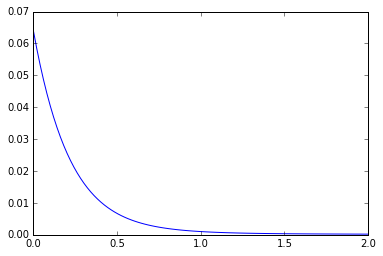

In [13]:
yvals = np.linspace(0, 2,100)

pl.figure()
pl.plot(yvals, np.vectorize(WD.calcwd)(0.1,0.1,yvals,'Xe131'))
pl.show()